## 転移学習で精度の向上

このノートでは転移学習で精度の向上を図れるのかを検証していきます。<br>
比較的複雑なモデルであるResNetを活用していきたいと思います。

In [7]:
# ライブラリのインポート
import os
import random
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import img_to_array,array_to_img
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam

## データの用意

単純に転移学習でどれくらい精度が変わるのかを見るために、<br>
全く同じデータを使用します。

In [3]:
X_train, X_test, y_train, y_test = np.load('./processed_images.npy',allow_pickle=True)

## Resnet構築

転移学習はシンプルにインプットを整えて、出力だけを変える形で実装していきます。<br>
全結合層は自分で実装していきますが、結果的によかったものを採用しました。<br>
転移学習では、学習回数が少なくて済むので時間的なコストもかかりません。

In [8]:
model = Sequential([
    layers.Input((150,150,3)),
    ResNet50V2(include_top=False,weights='imagenet',input_shape=(150,150,3)),
    layers.GlobalAveragePooling2D(),
    Dense(128,activation='relu'),
    Dense(128,activation='relu'),
    Dense(128,activation='relu'),
    Dense(6,activation='softmax'),
])
print(model.summary())

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 774       
Total params: 23,860,870
Trainable params: 23,815,430
N

In [9]:
adam = Adam(lr=0.0001)
model.compile(optimizer =adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
history = model.fit(X_train,y_train,epochs=5,batch_size=128, validation_split=0.1)

Epoch 1/5
79/79 [==============================] - 24s 301ms/step - loss: 0.0204 - accuracy: 0.9927 - val_loss: 0.3573 - val_accuracy: 0.9181
Epoch 2/5
79/79 [==============================] - 23s 295ms/step - loss: 0.0113 - accuracy: 0.9964 - val_loss: 0.3859 - val_accuracy: 0.9118
Epoch 3/5
79/79 [==============================] - 23s 295ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.3895 - val_accuracy: 0.9234
Epoch 4/5
79/79 [==============================] - 23s 295ms/step - loss: 0.0034 - accuracy: 0.9987 - val_loss: 0.4082 - val_accuracy: 0.9270
Epoch 5/5
79/79 [==============================] - 23s 295ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.4132 - val_accuracy: 0.9270


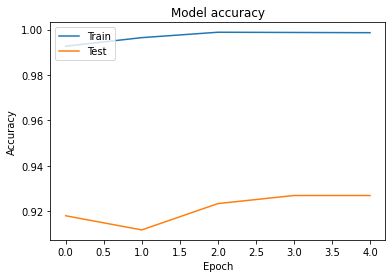

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

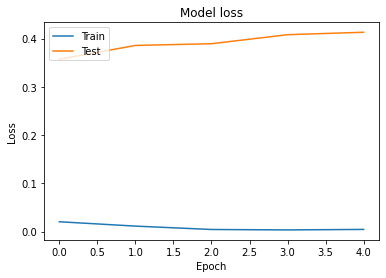

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim()
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
scores = model.evaluate(X_test,y_test)
print(f'Loss: {scores[0]}' )
print(f'Accuracy: {scores[1] * 100}' )

88/88 [==============================] - 3s 37ms/step - loss: 0.4034 - accuracy: 0.9238
Loss: 0.40342628955841064
Accuracy: 92.37620234489441


上の図だとそもそもズレがないので、非常にわかりにくいですが、<br>
普通に組んだモデルだと８０％の精度でしたが、<br>
９０％以上の精度を出しており、また訓練データとテストデータの差もほとんどありません。

## モデル予測

実際に合っているかも見ていきましょう。

In [19]:
# 予測データを格納
y_pred = model.predict(X_test)  

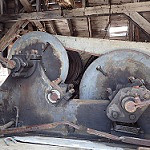

In [20]:
# 適当にデータを選ぶ
img = array_to_img(X_test[10])
img

In [21]:
labels = ['building','forest','glacier','mountain','sea','streeet']
print(labels)
print('実際の画像：',labels[np.argmax(y_test[10])])
print('予測：',labels[np.argmax(y_pred[10])])

['building', 'forest', 'glacier', 'mountain', 'sea', 'streeet']
実際の画像： glacier
予測： glacier


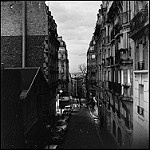

In [22]:
img = array_to_img(X_test[50])
img

In [23]:
labels = ['building','forest','glacier','mountain','sea','streeet']
print(labels)
print('実際の画像：',labels[np.argmax(y_test[50])])
print('予測：',labels[np.argmax(y_pred[50])])

['building', 'forest', 'glacier', 'mountain', 'sea', 'streeet']
実際の画像： streeet
予測： streeet


## まとめ

前回までは、ディープラーニングをなるべく自分で考えながら、<br>
パラメータ調整していくという趣旨で動かしましたが、今回はお手軽に高精度のAIが作れるように転移学習で行いました。

-  とにかく精度を上げたい！
-  学習に時間をかけられない
-  これ以上有効な調整がない

といった場合には転移学習を試してみることをお勧めします。<br>
しかし、転移させる学習器のドメインも関係するので注意が必要です。